# Описание проекта: "Отток клиентов"

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [Kaggle](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Инструкция по выполнению проекта
1. Загрузите и подготовьте данные. Поясните порядок действий.
1. Исследуйте баланс классов, обучите модель без учёта дисбаланса. Кратко опишите выводы.
1. Улучшите качество модели, учитывая дисбаланс классов. Обучите разные модели и найдите лучшую. Кратко опишите выводы.
1. Проведите финальное тестирование.

## Описание данных
Данные находятся в файле /datasets/Churn.csv (англ. «отток клиентов»). [Скачать датасет](https://code.s3.yandex.net/datasets/Churn.csv)

### Признаки
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

### Целевой признак
- Exited — факт ухода клиента

# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV # разбиение на выборки, подбор параметров
from sklearn.ensemble import RandomForestClassifier # случайный лес
from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.metrics import f1_score, precision_recall_curve, roc_auc_score, roc_curve # оценка качества
from sklearn.utils import shuffle

# from sklearn.dummy import DummyClassifier # бонус :) для проверки адекватности

In [2]:
# настройки
pd.set_option('float_format', '{:,.2f}'.format)

In [3]:
# задаем сразу необходимые типы данных, если необходимо
types = {
#     'example':'int64',
}
columns = [
    'RowNumber', # уникальный индекс
#     'CustomerId', # уникальное
#     'Surname', # для рассчетов не пригодится
    'CreditScore',
    'Geography',
    'Gender',
    'Age',
    'Tenure',
    'Balance',
    'NumOfProducts',
    'HasCrCard',
    'IsActiveMember',
    'EstimatedSalary',
    'Exited',
]
index='RowNumber'

In [4]:
# универсальное чтение данных
name = 'Churn.csv'
try:
    # local
    data = pd.read_csv("./datasets/" + name, dtype=types, usecols=columns, index_col=index)
except:
    try:
        # https://jupyterhub.praktikum-services.ru/
        data = pd.read_csv("/datasets/" + name, dtype=types, usecols=columns, index_col=index)
    except:
        # https://praktikum.yandex.ru/
        data = pd.read_csv("https://..." + name, dtype=types, usecols=columns, index_col=index)
finally:
    display(data.info())
    display(data.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 937.5+ KB


None

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
2,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
3,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
4,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
5,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


Данные хорошо подготовлены. Кроме пропусков в `Tenure` сразу не видно. Мультиколлениальности быть не должно

## Пропуски

Можно обратить внимание на колонку `Tenure`. В ней имеются пропуски. Смотрим подробнее:

In [5]:
data[data['Tenure'].isna()].sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
8570,622,Spain,Male,36,nan,0.00,2,1,1,"104,852.60",0
7565,598,Germany,Male,38,nan,"101,487.18",1,1,1,"75,959.10",1
6401,676,Spain,Female,30,nan,0.00,2,0,0,"179,066.58",0
1901,570,France,Female,33,nan,0.00,1,1,1,"124,641.42",0
4907,809,Spain,Female,33,nan,0.00,2,0,1,"141,426.78",0


In [6]:
len(data['Tenure'].unique())

12

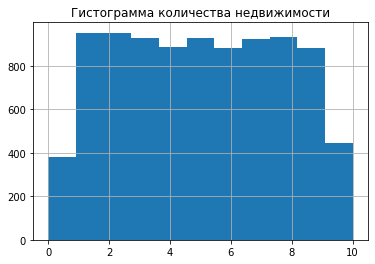

In [7]:
data['Tenure'].hist(bins=len(data['Tenure'].unique())-1)
plt.title('Гистограмма количества недвижимости')
plt.show()

Достаточно интересная гистограмма. Все значения от 1 до 9 включительно практически равны между собой, а вот количество клиентов без недвижимости или с 10 объектами проседают. Можно предположить, что именно эти значения были ~~потеряны~~ (или намеренно удалены)

Предположу, что 909 пропущенных значений могли быть потеряны из двух разных классов (1 и 10) (в добавок $\frac{10000}{11}\approx909 $ - совпадение - не думаю). Поэтому заполнять будет не совсем верно (хотя как вариант можно попробовать заполнить, ~~вернусь к этому если будет время~~). Удаляем пропуски:

In [8]:
data = data.dropna()

## Исследование баланса классов
Оценим с помощью графиков представленные данные

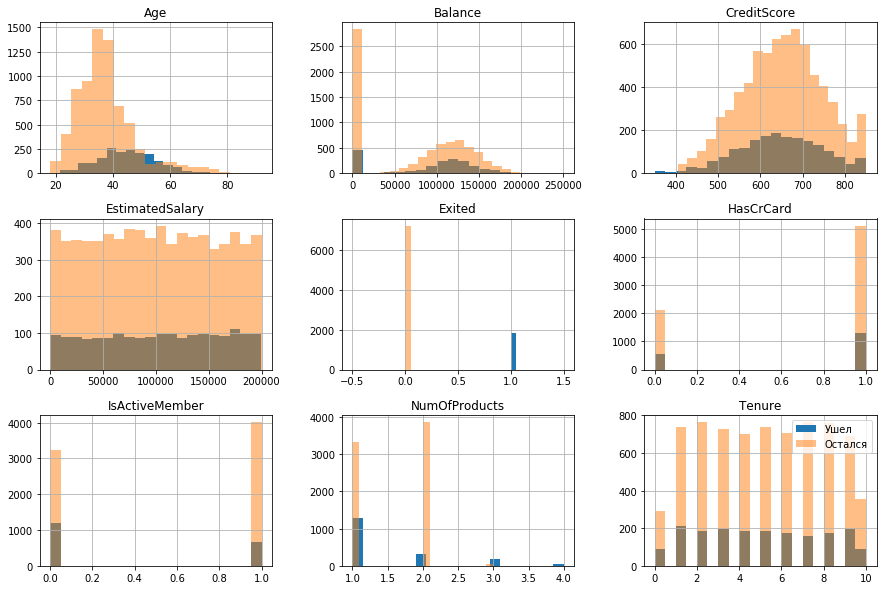

In [9]:
ax = data[data.Exited == 1].hist(bins=20, figsize=(15,10))
data[data.Exited == 0].hist(bins=20, ax=ax, alpha=0.5)
plt.legend(['Ушел','Остался'])
plt.show()

Обращаем внимание на гистограммы `Balance` и `Exited`.

Имеется явный всплеск клиентов с нулевым балансом. Как вариант, в дальнейшем можно попробовать исследовать качество моделей если добавить колонку `IsNullBalance` со значениями 0 или 1.

Также можно отметить, что ушедшие клиенты в среднем старше, чем оставшиеся.

По целевому признаку имеется явный дисбаланс (в 3.9 раза):

In [10]:
data['Exited'].value_counts()

0    7237
1    1854
Name: Exited, dtype: int64

## Подготовка данных
Преобразуем категориальные переменные

In [11]:
data_ohe = pd.get_dummies(data, columns=['Geography','Gender'], drop_first=True)

In [12]:
data_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,,
1,619,42,2.00,0.00,1,1,1,"101,348.88",1,0,0,0
2,608,41,1.00,"83,807.86",1,0,1,"112,542.58",0,0,1,0
3,502,42,8.00,"159,660.80",3,1,0,"113,931.57",1,0,0,0
4,699,39,1.00,0.00,2,0,0,"93,826.63",0,0,0,0
5,850,43,2.00,"125,510.82",1,1,1,"79,084.10",0,0,1,0


## Разделение данных

In [13]:
features = data_ohe.drop(columns='Exited')
target = data_ohe['Exited']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345, stratify='Exited')
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345, stratify='Exited')

In [14]:
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(5454, 11)
(1818, 11)
(1819, 11)


In [15]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
3707,629,44,6.00,"125,512.98",2,0,0,"79,082.76",0,1,0
6806,614,35,1.00,0.00,2,1,1,"3,342.62",0,0,0
4450,666,36,3.00,0.00,2,1,0,"35,156.54",0,0,1
599,683,57,5.00,"162,448.69",1,0,0,"9,221.78",1,0,0
1846,737,36,9.00,0.00,1,0,1,"188,670.90",0,0,1


## Масштабирование признаков
Выделяем числовые признаки с различным масштабом

In [16]:
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
3707,-0.20,0.47,0.35,0.79,0.78,0,0,-0.36,0,1,0
6806,-0.36,-0.38,-1.37,-1.23,0.78,1,1,-1.67,0,0,0
4450,0.18,-0.29,-0.68,-1.23,0.78,1,0,-1.12,0,0,1
599,0.35,1.71,0.01,1.38,-0.91,0,0,-1.57,1,0,0
1846,0.90,-0.29,1.39,-1.23,-0.91,0,1,1.54,0,0,1


Данные подготовлены для исследовательских задач, а именно:
- удалены имеющиеся пропуски
- определены признаки (и целевой признак)
- сформированы тренировочная, валидационная и тестовая выборки
- категориальные признаки были заменены
- числовые признаки отмасштабированы

По целевому признаку имеется **дисбаланс (в 3.9 раза)**

# 2. Исследование задачи

## Подбор гиперпараметров для моделей
Пробуем найти лучшие гиперпараметры для логистической регресии и случайного леса

### GridSearch для LogisticRegression

In [18]:
model = LogisticRegression(solver='liblinear')

parametrs = {
    'penalty':['l1', 'l2'],
    'C': np.arange(0.5, 3, 0.2)
}

In [19]:
%%time
grid = GridSearchCV(model, parametrs, scoring='f1', cv=5)
grid.fit(features_train, target_train)

grid.best_params_

CPU times: user 12.7 s, sys: 13 s, total: 25.7 s
Wall time: 25.8 s


{'C': 2.3, 'penalty': 'l2'}

Используем полученные значения далее

### GridSearch для RandomForestClassifier
Запускаем поиск гиперпараметров по сетке. Осторожно, может быть долго. Примерный диапазон поиска был подобран ранее и тут не показан

In [20]:
model = RandomForestClassifier()

parametrs = {
    'n_estimators': range (85, 95, 1), # кол-во деревьев
    'max_depth': range (10,15, 1), # максимальная глубина дерева
}

In [21]:
%%time
grid = GridSearchCV(model, parametrs, scoring='f1', cv=5)
grid.fit(features_train, target_train)

grid.best_params_

CPU times: user 2min 26s, sys: 0 ns, total: 2min 26s
Wall time: 2min 28s


{'max_depth': 11, 'n_estimators': 91}

Используем полученные значения далее

## Обучение модели без учета дисбаланса
### Логистическая регрессия
Определим функцию для удобства

In [22]:
def test_LR_model(features_train, target_train, features_valid, target_valid, class_weight=None):
    model = LogisticRegression(solver='liblinear', class_weight=class_weight, C=2.3, penalty='l2')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    predicted_valid_proba = model.predict_proba(features_valid)[:,1]

    # Проверяем качество модели по метрике F1
    print('F1 =', f1_score(target_valid, predicted_valid))
    # Проверяем качество модели по метрике ROC-AUC
    print('ROC-AUC =', roc_auc_score(target_valid, predicted_valid_proba))

In [23]:
test_LR_model(features_train, target_train, features_valid,target_valid)

F1 = 0.3004115226337448
ROC-AUC = 0.7725089945656265


### Случайный лес
Создаем функцию

In [24]:
def test_RFC_model(features_train, target_train, features_valid, target_valid, class_weight=None):
    model = RandomForestClassifier(random_state=12345, n_estimators=89, max_depth=14,)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    predicted_valid_proba = model.predict_proba(features_valid)[:,1]

    # Проверяем качество модели по метрике F1
    print('F1 =', f1_score(target_valid, predicted_valid))
    # Проверяем качество модели по метрике ROC-AUC
    print('ROC-AUC =', roc_auc_score(target_valid, predicted_valid_proba))

In [25]:
test_RFC_model(features_train, target_train, features_valid, target_valid)

F1 = 0.5524475524475525
ROC-AUC = 0.8318834770958468


Значение метрики F1 и ROC-AUC у случайного леса значительно выше чем у модели на основе логистической регрессии (вполне очевидно). Но до требуемого 0.59 немного не дотягивает. Вероятно сказывается дисбаланс классов. Пробуем улучшить значения F-меры

# 3. Борьба с дисбалансом

## Использование `class_weight='balanced'`

### Логистическая регрессия

In [26]:
test_LR_model(features_train, target_train, features_valid, target_valid, class_weight='balanced')

F1 = 0.49506903353057197
ROC-AUC = 0.7747312920561803


F1-мера увеличилась с 0.3 до 0.5. Неплохой показатель. При этом ROC-AUC не изменилась. Теперь оценим модель на основе случайного леса

### Случайный лес

In [27]:
test_RFC_model(features_train, target_train, features_valid, target_valid, class_weight='balanced')

F1 = 0.5524475524475525
ROC-AUC = 0.8318834770958468


Ничего не изменилось. Получается, что этот гиперпараметр в этой ситуации не влияет на F1

## UP-sampling
Определим функцию:

In [28]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

<div class="alert alert-success">
<h2> Комментарий ревьюера</h2>

Хорошо, что попробовали увеличение выборки и обернули этот метод в функцию. 
    
</div>

In [29]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

### Логистическая регрессии

In [30]:
test_LR_model(features_upsampled, target_upsampled, features_valid, target_valid)

F1 = 0.4956605593056895
ROC-AUC = 0.7748253774706829


Результат схож с предыдущим экспериментом

### Случайный лес

In [31]:
test_RFC_model(features_upsampled, target_upsampled, features_valid, target_valid)

F1 = 0.5965417867435159
ROC-AUC = 0.8402655466738923


Показатель F1 увеличился на 0.04. Уже немного больше порогового значения в 0.59. ROC-AUC также немного вырос. Смотрим далее

## DOWN-sampling
Определим функцию:

In [32]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [33]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

### Логистическая регрессии

In [34]:
test_LR_model(features_downsampled, target_downsampled, features_valid, target_valid)

F1 = 0.5004906771344456
ROC-AUC = 0.7754463412064009


В рамках погрешности.

### Случайный лес

In [35]:
test_RFC_model(features_downsampled, target_downsampled, features_valid, target_valid)

F1 = 0.5826086956521739
ROC-AUC = 0.8395147450661609


Немного хуже, но в рамках погрешности.

## Изменение порога

Создадим функцию построения PR-кривой для выбранного метода. Потому что могу и хочу!!! :) Ну и всё-таки Recall и Precision непосредственно связаны с F1

In [36]:
def PR_curve(target_valid, probabilities_valid, method=''):
    precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

    plt.figure(figsize=(6, 6))
    plt.step(recall, precision, where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Кривая Precision-Recall {method}')
    plt.show()

Функция для построения ROC-кривой

In [37]:
def ROC_curve(target_valid, probabilities_valid, method=''):
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_valid[:, 1])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC-кривая {method}")
    plt.show()

### Логистическая регрессии
Меняем значения порога классификации и смотрим, как меняется F1

In [38]:
model = LogisticRegression(solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(.04, .4, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

    print("Порог = {:.2f} | F1 = {:.3f} | ROC-AUC = {:.3f}".format(threshold, f1, roc_auc))

Порог = 0.04 | F1 = 0.343 | ROC-AUC = 0.773
Порог = 0.06 | F1 = 0.369 | ROC-AUC = 0.773
Порог = 0.08 | F1 = 0.396 | ROC-AUC = 0.773
Порог = 0.10 | F1 = 0.419 | ROC-AUC = 0.773
Порог = 0.12 | F1 = 0.441 | ROC-AUC = 0.773
Порог = 0.14 | F1 = 0.454 | ROC-AUC = 0.773
Порог = 0.16 | F1 = 0.471 | ROC-AUC = 0.773
Порог = 0.18 | F1 = 0.478 | ROC-AUC = 0.773
Порог = 0.20 | F1 = 0.483 | ROC-AUC = 0.773
Порог = 0.22 | F1 = 0.497 | ROC-AUC = 0.773
Порог = 0.24 | F1 = 0.494 | ROC-AUC = 0.773
Порог = 0.26 | F1 = 0.499 | ROC-AUC = 0.773
Порог = 0.28 | F1 = 0.484 | ROC-AUC = 0.773
Порог = 0.30 | F1 = 0.482 | ROC-AUC = 0.773
Порог = 0.32 | F1 = 0.486 | ROC-AUC = 0.773
Порог = 0.34 | F1 = 0.465 | ROC-AUC = 0.773
Порог = 0.36 | F1 = 0.438 | ROC-AUC = 0.773
Порог = 0.38 | F1 = 0.417 | ROC-AUC = 0.773


Максимальное значение (0.5) F1 для логистической регрессии наблюдается при значении порога 0.26. ROC-AUC не меняется, что вполне логично

Посмотрим на график PR

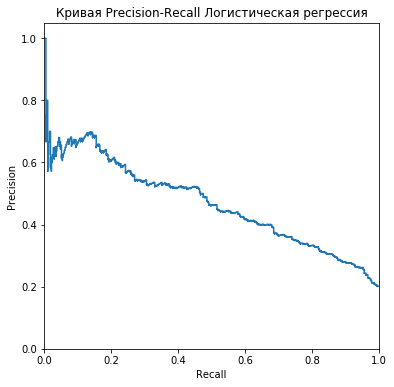

In [39]:
PR_curve(target_valid, probabilities_valid, method='Логистическая регрессия')

График ROC

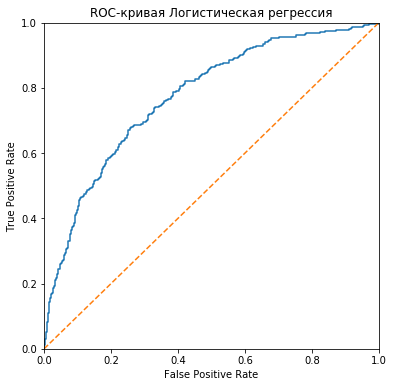

In [40]:
ROC_curve(target_valid, probabilities_valid, method='Логистическая регрессия')

### Случайный лес

Меняем значения порога классификации и смотрим, как меняется F1

In [41]:
model = RandomForestClassifier(random_state=12345, max_depth=14,min_samples_split=4,n_estimators=89)
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(.3, .6, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    f1 = f1_score(target_valid, predicted_valid)
    roc_auc = roc_auc_score(target_valid, probabilities_one_valid)

    print("Порог = {:.2f} | F1 = {:.3f} | ROC-AUC = {:.3f}".format(threshold, f1, roc_auc))

Порог = 0.30 | F1 = 0.596 | ROC-AUC = 0.836
Порог = 0.32 | F1 = 0.602 | ROC-AUC = 0.836
Порог = 0.34 | F1 = 0.604 | ROC-AUC = 0.836
Порог = 0.36 | F1 = 0.617 | ROC-AUC = 0.836
Порог = 0.38 | F1 = 0.603 | ROC-AUC = 0.836
Порог = 0.40 | F1 = 0.597 | ROC-AUC = 0.836
Порог = 0.42 | F1 = 0.597 | ROC-AUC = 0.836
Порог = 0.44 | F1 = 0.584 | ROC-AUC = 0.836
Порог = 0.46 | F1 = 0.578 | ROC-AUC = 0.836
Порог = 0.48 | F1 = 0.584 | ROC-AUC = 0.836
Порог = 0.50 | F1 = 0.566 | ROC-AUC = 0.836
Порог = 0.52 | F1 = 0.540 | ROC-AUC = 0.836
Порог = 0.54 | F1 = 0.528 | ROC-AUC = 0.836
Порог = 0.56 | F1 = 0.518 | ROC-AUC = 0.836
Порог = 0.58 | F1 = 0.507 | ROC-AUC = 0.836


Максимальное значение (0.617) F1 для случайного леса наблюдается при значении порога 0.36

Оценим модель по PR-кривой

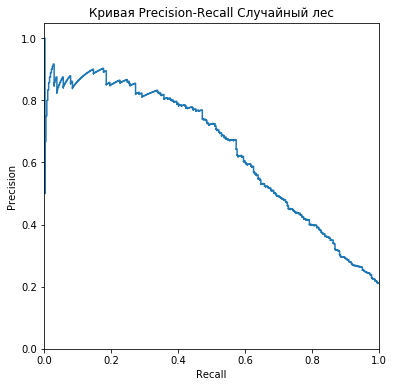

In [42]:
PR_curve(target_valid, probabilities_valid, method='Случайный лес')

Площадь графика под кривой немного больше, чем у логистической регрессии, что говорит о лучшем качестве модели.

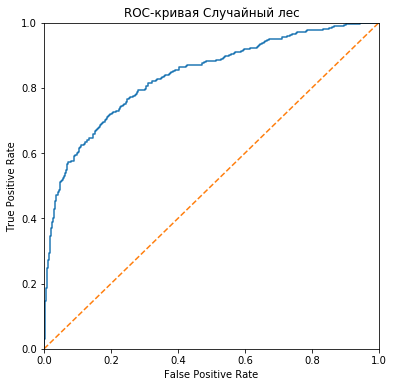

In [43]:
ROC_curve(target_valid, probabilities_valid, method='Случайный лес')

Случайный лес показывает лучшее качество, причем с небольшим запасом от требуемого 0.59 по F1.

Во всех результатах случайный лес показывает лучшее значение F1, чем логистическая регрессии. При этом при UP-sampling'е показатели немного лучше (если сравнивать с `class_weight` и DOWN-sampling). Но лучшее значение F1 было найдено при изменении порога.

# 4. Тестирование модели

Определяем лучшие гиперпараметры и порог принятия решения:

In [44]:
threshold = 0.36
model = RandomForestClassifier(random_state=12345, max_depth=14, min_samples_split=4, n_estimators=89)

Обучаем модель по тренировочной и валидационной выборке. И оцениваем качество модели

In [45]:
features = features_train.append(features_valid)
target = target_train.append(target_valid)

model.fit(features, target)
probabilities_one_valid = model.predict_proba(features_test)[:, 1]
predicted_valid = probabilities_one_valid > threshold

f1 = f1_score(target_test, predicted_valid)
roc_auc = roc_auc_score(target_test, probabilities_one_valid)

print("Порог = {:.2f} | F1 = {:.3f} | ROC-AUC = {:.3f}".format(threshold, f1, roc_auc))

Порог = 0.36 | F1 = 0.625 | ROC-AUC = 0.861


Требуемое значение F1 на тестовой выборке достигнуто.

Возможные стратегии повышения метрик:
- заполнение имеющихся пропусков (а не удаление)
- добавление фичи для клиентов с нулевым балансом (на гистограммах видно, что таких клиентов много и из-за этого мода для баланса = 0)
- исследование других гиперпараметров для модели случайного леса/регрессии
- исследование других моделей

В целевом признаке имеется дисбаланс в 3.9 раза. После исследования различных способов борьбы с дисбалансом классов, был выбран другой порог принятия решения.